<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [1]:
import json
import pandas as pd
import psycopg2
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from bs4 import BeautifulSoup

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

In [2]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python 
# Парметры подключения загрузим из файла
with open('creds.json') as fin:
    creds = json.load(fin)
    
DBNAME = creds['DBNAME']
USER = creds['USER']
PASSWORD = creds['PASSWORD']
HOST = creds['HOST']
PORT = creds['PORT']

In [3]:
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [4]:
# текст запроса
query_3_1 = '''
SELECT count(*)
FROM vacancies
'''

In [5]:
# результат запроса
pd.read_sql_query(query_3_1, connection)

,count
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [6]:
# текст запроса
query_3_2 = '''
SELECT count(*)
FROM employers
'''

In [7]:
# результат запроса
pd.read_sql_query(query_3_2, connection)

,count
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [8]:
# текст запроса
query_3_3 = '''
SELECT count(*)
FROM areas
'''

In [9]:
# результат запроса
pd.read_sql_query(query_3_3, connection)

,count
0,1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [10]:
# текст запроса
query_3_4 = '''
SELECT count(*)
FROM industries
'''

In [11]:
# результат запроса
pd.read_sql_query(query_3_4, connection)

,count
0,294


***

 \# выводы по предварительному анализу данных
* Для анализа имеем базу данных с пятью таблицами и четырьмя сущностями. 
* В среднем на одного работодателя приходится около двух вакансий.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [12]:
# текст запроса
query_4_1 = '''
SELECT 
    a.name area, 
    COUNT(v.id) cnt
FROM areas a
JOIN vacancies v ON v.area_id = a.id
GROUP BY a.id
ORDER BY cnt DESC
'''

In [13]:
# результат запроса
pd.read_sql_query(query_4_1, connection)

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Кизляр,1
765,Джизак,1
766,Эртиль,1
767,Арсеньев,1


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [14]:
# текст запроса
query_4_2 = '''
SELECT COUNT(*)
FROM vacancies v
WHERE v.salary_from IS NOT NULL 
    OR v.salary_to IS NOT NULL
'''

In [15]:
# результат запроса
pd.read_sql_query(query_4_2, connection)

,count
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [16]:
# текст запроса
query_4_3 = '''
SELECT 
    ROUND(AVG(v.salary_from)) avg_from,
    ROUND(AVG(v.salary_to)) avg_to
FROM vacancies v
WHERE v.salary_from IS NOT NULL 
    OR v.salary_to IS NOT NULL
'''

In [17]:
# результат запроса
pd.read_sql_query(query_4_3, connection)

,avg_from,avg_to
0,71065.0,110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [18]:
# текст запроса
query_4_4 = '''
SELECT 
    v.schedule, 
    v.employment, 
    COUNT(*)
FROM vacancies v
GROUP BY v.schedule, v.employment
ORDER BY COUNT(*) DESC
'''

In [19]:
# результат запроса
pd.read_sql_query(query_4_4, connection)

,schedule,employment,count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [20]:
# текст запроса
query_4_5 = '''
SELECT 
    v.experience, 
    COUNT(*)
FROM vacancies v
GROUP BY v.experience
ORDER BY COUNT(*)
'''

In [21]:
# результат запроса
pd.read_sql_query(query_4_5, connection)

,experience,count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

\# выводы по детальному анализу вакансий
* Подавляющее большинство вакансий предлагают полную занятость на полный день.
* Предлагаемую зарплату указывают не все работодатели, примерно только в половине случаев.
* Указанная зарплата находится в диапазоне от 71065 до 110537 рублей.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [22]:
# текст запроса
query_5_1 = '''
SELECT 
    e.name, 
    COUNT(*)
FROM vacancies v
JOIN employers e ON e.id = v.employer_id
GROUP BY e.id, e.name
ORDER BY COUNT(*) DESC
LIMIT 5
'''

In [23]:
# результат запроса
pd.read_sql_query(query_5_1, connection)

,name,count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [24]:
# текст запроса
query_5_2 = '''
SELECT 
    a.name, 
    count(distinct e.id) employers_cnt, 
    count(distinct v.id) vacancies_cnt
FROM areas a
JOIN employers e ON e.area = a.id
LEFT JOIN vacancies v ON v.area_id = a.id
GROUP by a.id, v.id
HAVING v.id IS NULL
ORDER BY employers_cnt DESC
LIMIT 1
'''

In [25]:
# результат запроса
pd.read_sql_query(query_5_2, connection)

,name,employers_cnt,vacancies_cnt
0,Россия,410,0


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [26]:
# текст запроса
query_5_3 = '''
SELECT 
    e.id employer_id,
    e.name employer_name,
    count(distinct v.area_id) areas_cnt
FROM employers e
JOIN vacancies v ON v.employer_id = e.id
GROUP by e.id
ORDER BY areas_cnt DESC
'''

In [27]:
# результат запроса
pd.read_sql_query(query_5_3, connection)

,employer_id,employer_name,areas_cnt
0,1740,Яндекс,181
1,2748,Ростелеком,152
2,5724811,Спецремонт,116
3,5130287,Поляков Денис Иванович,88
4,3682876,ООО ЕФИН,71
...,...,...,...
14901,810278,НПП Авиатрон,1
14902,810313,Центр дистанционных торгов,1
14903,810551,Городские Телекоммуникационные Системы,1
14904,810688,"Введенский, Отель",1


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [28]:
# текст запроса
query_5_4 = '''
SELECT COUNT(*)
FROM employers e
LEFT JOIN employers_industries ei ON ei.employer_id = e.id
WHERE ei.industry_id IS NULL
'''

In [29]:
# результат запроса
pd.read_sql_query(query_5_4, connection)

,count
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [30]:
# текст запроса
query_5_5 = '''
SELECT 
    e.name employer, 
    COUNT(ei.industry_id) industries_cnt
FROM employers e
LEFT JOIN employers_industries ei ON ei.employer_id = e.id
GROUP BY e.id
HAVING COUNT(ei.industry_id) = 4
ORDER BY e.name
LIMIT 1
OFFSET 2
'''

In [31]:
# результат запроса
pd.read_sql_query(query_5_5, connection)

,employer,industries_cnt
0,2ГИС,4


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [32]:
# текст запроса
query_5_6 = '''
SELECT 
    COUNT(e.id) employer_cnt
FROM employers e
JOIN employers_industries ei ON ei.employer_id = e.id
JOIN industries i ON i.id = ei.industry_id
GROUP BY i.id
HAVING i.name = 'Разработка программного обеспечения'
'''

In [33]:
# результат запроса
pd.read_sql_query(query_5_6, connection)

,employer_cnt
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [34]:
# код для получения списка городов-милионников
response = requests.get('https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8#%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D0%BE%D0%B2')
parsed = BeautifulSoup(response.text)
rows = (
    parsed.find(id='Список_городов-миллионеров')  # находим заголовок таблицы
    .parent  # h3 на одном уровне с таблицей
    .find_next_sibling('table')  # находим саму таблицу
    .find_all('tr')  # выбираем строки таблицы
)
cities = [r.find_all('td')[1].text for r in rows[1:]]  # из строк таблицы выбираем текст со второй по порядку ячейке
cities_str = ','.join(f"'{city}'" for city in cities)  # объединяем города в строку для SQL-запроса
cities_str

"'Москва','Санкт-Петербург','Новосибирск','Екатеринбург','Казань','Нижний Новгород','Красноярск','Челябинск','Самара','Уфа','Ростов-на-Дону','Краснодар','Омск','Воронеж','Пермь','Волгоград'"

In [35]:
# текст запроса
query_5_7 = f'''
WITH Cities_vacancies AS (
-- сначала подготовим таблицу с расчетом количества вакансий по городам-миллионникам
    SELECT 
        a.name,
        COUNT(v.id) vacancies_cnt
    FROM employers e
    JOIN vacancies v ON v.employer_id = e.id
    JOIN areas a ON a.id = v.area_id
    WHERE e.name = 'Яндекс' 
        AND a.name IN ({cities_str})
    GROUP BY e.id, a.id
)
SELECT 
    name, 
    vacancies_cnt
FROM Cities_vacancies
UNION ALL  -- к таблице с вакансиями по городам добавим таблицу с суммой по этим городам 
SELECT 
    'Total',
    SUM(vacancies_cnt) 
FROM Cities_vacancies
ORDER BY vacancies_cnt
'''

In [36]:
# результат запроса
pd.read_sql_query(query_5_7, connection)

,name,vacancies_cnt
0,Омск,21.0
1,Челябинск,22.0
2,Красноярск,23.0
3,Волгоград,24.0
4,Ростов-на-Дону,25.0
5,Казань,25.0
6,Пермь,25.0
7,Уфа,26.0
8,Самара,26.0
9,Краснодар,30.0


***

\# выводы по анализу работодателей
* Работодатели зачастую не указывают их отрасль деятельности, на данные об отраслях сложно будет полагаться при анализе.
* В данной базе широко представлены ИТ-вакансии. Возможно, из этих данных сложно будет делать выводы о других отраслях.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [37]:
# текст запроса
query_6_1 = '''
SELECT 
    COUNT(v.name)
FROM vacancies v
WHERE v.name ILIKE '%data%' 
    OR v.name ILIKE '%данн%' 
'''

In [38]:
# результат запроса
pd.read_sql_query(query_6_1, connection)

,count
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [39]:
# текст запроса
"""
Cохраним условие отбора DS для дальнейшего использования.

Внезапно некоторые задачи сходятся с ответом на платформе только 
с неправильным условием (v.name LIKE '%ML%' AND v.name NOT LIKE '%HTML%'), 
которое пропускает, например, TeamLead.
"Правильное" условие тоже пропускает такое: "C++ разработчик (QML)", "Разработчик С++/QML",
"Бизнес-аналитик (AML и валютный контроль)", "Бизнес-аналитик (на оптимизацию опер.инструментов AML)"
Но по ответам на платформе сходятся следующие два условия
"""
ds_clause1 = '''
    (v.name ILIKE '%data scientist%' 
    OR v.name ILIKE '%data science%'
    OR v.name ILIKE '%исследователь данных%' 
    OR (v.name LIKE '%ML%' AND v.name NOT LIKE '%HTML%')
    OR v.name ILIKE '%machine learning%' 
    OR v.name ILIKE '%машинн%обучен%')
'''
ds_clause2 = '''
    (v.name ILIKE '%data scientist%' 
    OR v.name ILIKE '%data science%'
    OR v.name ILIKE '%исследователь данных%' 
    OR (v.name ILIKE '%ML%' AND v.name NOT ILIKE '%HTML%')
    OR v.name ILIKE '%machine learning%' 
    OR v.name ILIKE '%машинн%обучен%')
'''
print('Неправильное условие для DS (пример)')
df = pd.read_sql_query(f'''
        SELECT 
           v.name, v.key_skills
        FROM vacancies v
        WHERE {ds_clause2}
            AND v.key_skills IS NOT NULL
    ''', 
    connection
)
display(df[df['name'].str.contains('ml', case=False)])

# Решение
query_6_2 = f'''
SELECT 
    COUNT(v.name)
FROM vacancies v
WHERE {ds_clause1}
    AND (v.name ILIKE '%junior%'
        OR v.experience ILIKE '%Нет опыта%'
        OR v.employment ILIKE '%Стажировка%')
'''

Неправильное условие для DS (пример)


,name,key_skills
0,Junior+ CV/ML developer,Python\tSQL\tРабота в команде\tOpenCV\tML
3,AI/ML Senior Engineer,Python\tFlask\tLinux\tAWS\tGit
4,QA Automation TeamLead,Atlassian Jira\tФункциональное тестирование\tS...
5,PHP Senior/TeamLead,Разработка ПО\tJavaScript\tSQL\tMySQL\tВеб-про...
10,AI/ML Senior Engineer,Python\tFlask\tLinux\tAWS\tGit
...,...,...
474,Специалист ML/DS,Python\tNumpy\tPyTorch\tPandas\tМатематический...
476,C++ разработчик (QML),Qt\tООП\tC++\tMS Visual Studio\tРазработка ком...
478,ML Engineer Team Lead (to Cyprus),Python\tLinux\tKubernetes\tAWS\tGit\tPeople Ma...
479,Системный аналитик /Middle+/Senior/TeamLead,UML\tSQL\tBPMN\tSOAP\tREST\tПостановка задач р...


In [40]:
# результат запроса
pd.read_sql_query(query_6_2, connection)

,count
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [41]:
# текст запроса
query_6_3 = f'''
SELECT 
    COUNT(v.name)
FROM vacancies v
WHERE {ds_clause2}
    AND (v.key_skills ILIKE '%SQL%'
        OR v.key_skills ILIKE '%postgres%')
'''

In [42]:
# результат запроса
pd.read_sql_query(query_6_3, connection)

,count
0,229


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [43]:
# текст запроса
query_6_4 = f'''
SELECT 
    COUNT(v.name)
FROM vacancies v
WHERE {ds_clause2}
    AND v.key_skills ILIKE '%python%'
'''

In [44]:
# результат запроса
pd.read_sql_query(query_6_4, connection)

,count
0,357


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [45]:
# текст запроса
query_6_5 = f'''
SELECT 
    ROUND(
     AVG(
      ARRAY_LENGTH(
       STRING_TO_ARRAY(v.key_skills, '\t'), 1)),  -- разбиваем строку на массив
    2)
FROM vacancies v
WHERE {ds_clause1}
    AND v.key_skills IS NOT NULL
'''

In [46]:
# результат запроса
pd.read_sql_query(query_6_5, connection)

,round
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [47]:
# текст запроса
query_6_6 = f'''
SELECT 
    ROUND(
     AVG(
      (COALESCE(v.salary_from, v.salary_to)  -- если одна из границ зарплаты не указана, то берем вторую дважды и делим пополам
       + COALESCE(v.salary_to, v.salary_from)) / 2)) salary
FROM vacancies v
WHERE {ds_clause1}
    AND (v.salary_from IS NOT NULL 
         OR v.salary_to IS NOT NULL)
GROUP BY v.experience
HAVING v.experience = 'От 3 до 6 лет'
'''

In [48]:
# результат запроса
pd.read_sql_query(query_6_6, connection)

,salary
0,243115.0


***

\# выводы по предметному анализу
* Данные требуют детального анализа и абсолютного понимания, чтобы не допускать ошибок.
* Людям без опыта зайти в DS будет нелегко, т.к. вакансий для джуниоров и людей без опыта относительно мало.
* Python для DS на 50% более востребованный навык, чем навыки работы с SQL и PostgreSQl.  

# Общий вывод по проекту

In [49]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования

### Дополнительные исследования по зарплате

In [50]:
query = f'''
SELECT 
    v.experience,
    ROUND(
     AVG(
      (COALESCE(v.salary_from, v.salary_to)  -- если одна из границ зарплаты не указана, то берем вторую дважды и делим пополам
       + COALESCE(v.salary_to, v.salary_from)) / 2)) salary,
    a.name city
FROM vacancies v
JOIN areas a ON a.id = v.area_id
WHERE v.salary_from IS NOT NULL 
    OR v.salary_to IS NOT NULL
GROUP BY v.experience, a.name
'''
df = pd.read_sql_query(query, connection)

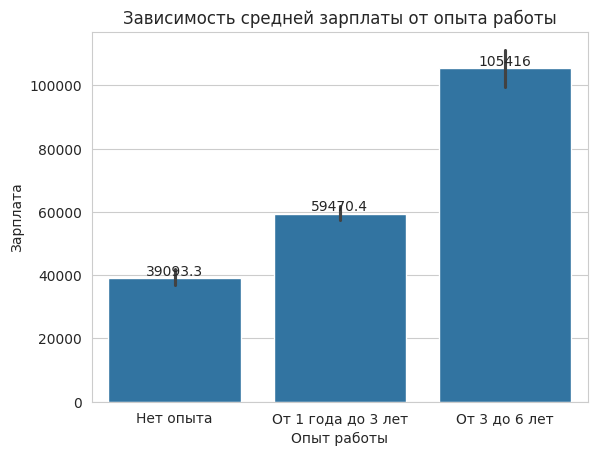

In [51]:
ax = sns.barplot(data=df, x='experience', y='salary', order=['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет'])
ax.set_title('Зависимость средней зарплаты от опыта работы')
ax.set(xlabel='Опыт работы', ylabel='Зарплата')
ax.bar_label(ax.containers[0]);

In [52]:
def set_city(row):
    if row in ['Москва', 'Санкт-Петербург']:
        return row
    if row in cities:
        return 'Город-миллионник'
    return 'другие'

df['city'] = df['city'].apply(set_city)

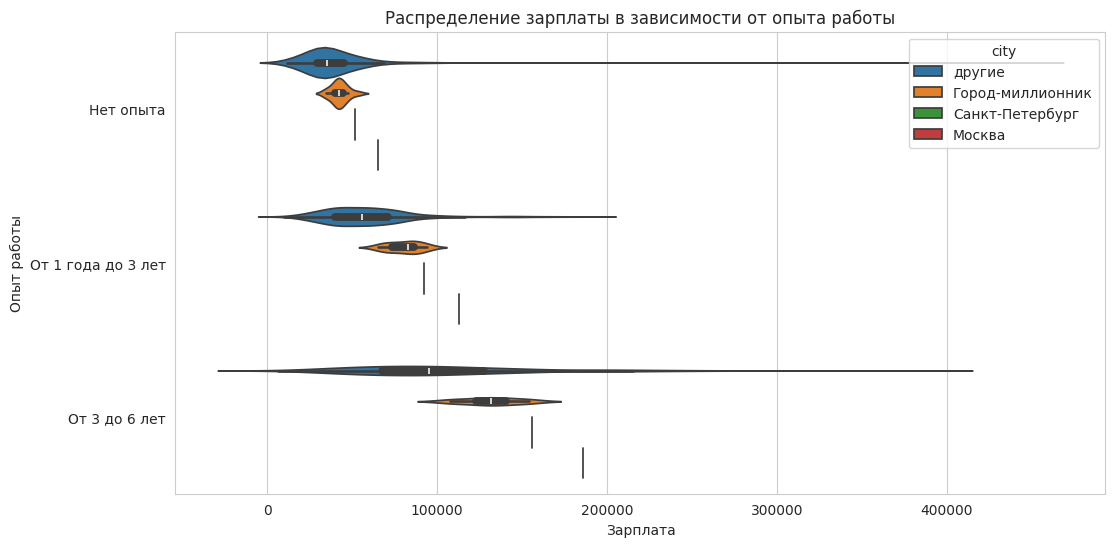

In [53]:
plt.figure(figsize=(12,6))
ax = sns.violinplot(df, y='experience', x='salary', hue='city',
                    order=['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет'])
ax.set(xlabel='Зарплата', ylabel='Опыт работы')
ax.set_title('Распределение зарплаты в зависимости от опыта работы');

In [54]:
df['city'].value_counts()

city
другие              1345
Город-миллионник      56
Санкт-Петербург        4
Москва                 4
Name: count, dtype: int64

#### Выводы по зарплате
Из 49197 вакансий зарплата в каком-то виде указана только для 1409. Делать общие выводы о зарплате по данным этой базы не имеет смысла. Можно указать только, что специалисты с опытом от трех лет и выше могут расчитывать на зарплату почти в три раза выше, чнм люди без опыта.

### Дополнительные исследования по количеству вакансий по регионам

Найдем среди предлагаемых специальностей долю специальностей, связанных с DS, в зависимости от региона. Регионы обобщим до набора: 'Москва', 'Санкт-Петербург', 'Город-миллионник', 'другие'.   
Для этого сначала объединим запросы, которые создают флаг DS-специальности (True/False). Затем сгруппируем полученную таблицу по рагионам.

In [55]:
query = f'''
SELECT 
    a.name city,
    true ds_related
FROM vacancies v
JOIN areas a ON a.id = v.area_id
WHERE {ds_clause1}
UNION ALL
SELECT 
    a.name city,
    false ds_related
FROM vacancies v
JOIN areas a ON a.id = v.area_id
WHERE NOT {ds_clause1}
'''
df = pd.read_sql_query(query, connection)

In [56]:
df['city'] = df['city'].apply(set_city)

In [57]:
grouped = df.groupby('city', as_index=False)['ds_related'].agg('mean', )

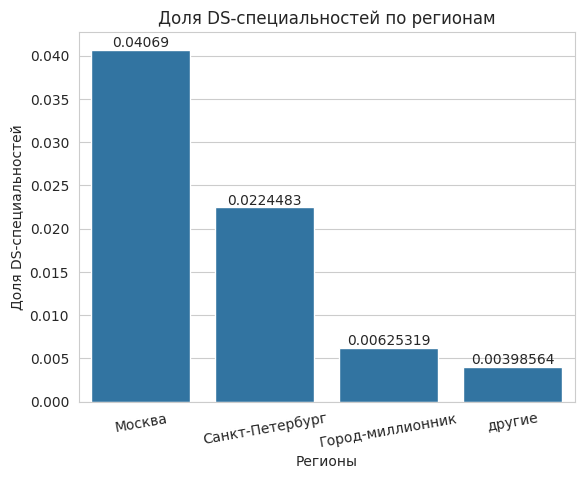

In [58]:
ax = sns.barplot(data=grouped, x='city', y='ds_related', 
                 order=['Москва', 'Санкт-Петербург', 'Город-миллионник', 'другие'])
ax.set_title('Доля DS-специальностей по регионам')
ax.set(xlabel='Регионы', ylabel='Доля DS-специальностей')
ax.tick_params(axis='x', rotation=10)
ax.bar_label(ax.containers[0]);

#### Выводы по исследованию доли DS-специальностей по регионам
Очевидно, что в Москве доля DS-специальностей многократно выше, чем в других регионах. Только Санкт-Петербург имеет долю только в два раза ниже. Следовательно, поиск работы по DS-специальности в Москве будет эффективнее, чем в других регионах.